In [1]:
%matplotlib inline

In [9]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pygsp
from pygsp import graphs, filters
import networkx as nx

In [10]:
Gnx = nx.read_gpickle('graph_with_delta_signal.gpickle')

In [11]:
len(Gnx.nodes), len(Gnx.edges)

(500, 5675)

In [12]:
Gnx.node['Stan Lee']

{'delta': 2397788}

In [13]:
nodes = np.array(Gnx.nodes())
delta = nx.get_node_attributes(Gnx, 'delta')
signal = np.array([delta[n] for n in nodes])

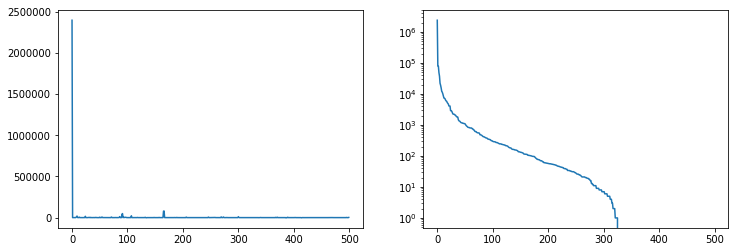

In [8]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.subplot(1,2,2)
plt.semilogy(sorted(signal, reverse=True))

In [8]:
# look at what pages got the highest delta
list(zip(nodes[signal>1000],signal[signal>10000]))

[('Stan Lee', 2397788),
 ('Disney Legends', 10095),
 ('Marvel Cinematic Universe', 19144),
 ('Larry Lieber', 15650),
 ('Don Heck', 12240),
 ('George W. Bush', 37743),
 ('Marvel Universe', 48962),
 ('Silver Surfer', 22206),
 ('Joe Simon', 78874),
 ('Jim Lee', 80108),
 ('DC Comics Presents', 11426)]

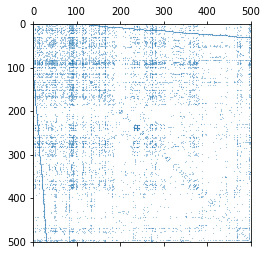

In [9]:
# make graph undirected & remove self loops
A = nx.adjacency_matrix(Gnx).todense()
A = np.logical_or(A, A.T).astype(int)
np.fill_diagonal(A, 0)
A = np.array(A)
adjacency = sparse.csr_matrix(A)

plt.spy(adjacency, markersize=0.1)

In [10]:
#sparse.csr_matrix(A)
n_nodes = A.shape[0]
D = sparse.diags(np.sum(A, axis=0))
D_inv_sq = sparse.diags(1 / np.sqrt(np.sum(A,axis=0)))
laplacian_combinatorial = D - adjacency
laplacian_normalized = sparse.eye(n_nodes) - D_inv_sq @ adjacency @ D_inv_sq.T

In [11]:
#eig_val, U = np.linalg.eigh(laplacian_normalized)
eig_val, U = sparse.linalg.eigsh(laplacian_normalized, k=20, which='SM')
U_norm = D_inv_sq @ U # renormalize for eigenmap visualizatio
eigenmap = U[:,1:3]

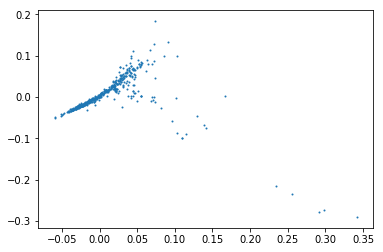

In [12]:
plt.scatter(U[:, 1], U[:, 2], s=1)

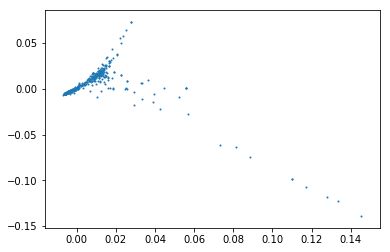

In [13]:
plt.scatter(U_norm[:, 1], U_norm[:, 2], s=1)

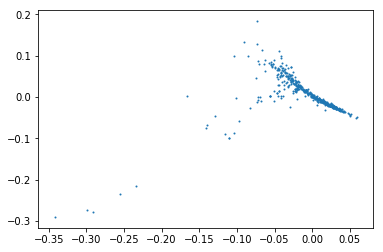

In [14]:
#G = pygsp.graphs.Graph(adjacency, lap_type='combinatorial')
G = pygsp.graphs.Graph(sparse.csr_matrix(A), lap_type='normalized')
eig_val, U = sparse.linalg.eigsh(G.L, k=20, which='SM')
plt.scatter(U[:, 1], U[:, 2], s=1)

In [15]:
#G.set_coordinates(kind='spring')
G.set_coordinates(U[:,1:3])

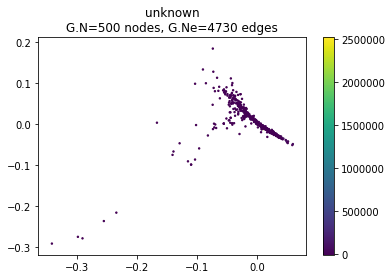

In [16]:
G.plot_signal(signal, vertex_size=2, show_edges=False)

In [17]:
eigenval_comb, eigen_vec_comb = np.linalg.eigh(laplacian_combinatorial.toarray())

In [18]:
e, U = eigenval_comb, eigen_vec_comb

def GFT(x):
    return  np.matmul(U.T,x) # U.T= U^-1 because orthonormal 

def iGFT(x):
    return np.matmul(U,x) 

def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    g = 1/(1 + t*e)
    return g

def rectangle_kernel(e, l_min, l_max):
    cond = np.logical_and(e >= l_min, e <= l_max)
    return np.where(cond, 1, 0)

def graph_filter(x, kernel, **kwargs):
    e = eigenval_comb
    g = kernel(e, **kwargs)
    return iGFT(np.matmul(np.diag(g),GFT(x)))

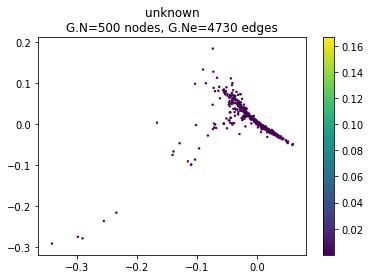

In [19]:
dirac = np.zeros(n_nodes);
dirac[nodes=='Stan Lee'] = 1;
x = graph_filter(dirac, heat_kernel, t=0.01)
G.plot_signal(x, vertex_size=2, show_edges=False)

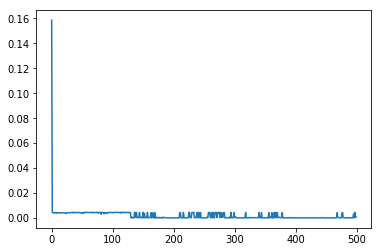

In [20]:
plt.plot(x)